In [2]:
import torch
import pandas as pd
import numpy as np
import os
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Evaluation
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
import pickle

def save(filename, *args):
    # Get global dictionary
    glob = globals()
    d = {}
    for v in args:
        # Copy over desired values
        d[v] = glob[v]
    with open(filename, 'wb') as f:
        # Put them in the file 
        pickle.dump(d, f)

def load(filename):
    # Get global dictionary
    glob = globals()
    with open(filename, 'rb') as f:
        for k, v in pickle.load(f).items():
            # Set each global variable to the value from the file
            glob[k] = v

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


## Load Data

In [5]:
data_file = os.path.join(os.getcwd(), "data.csv")
df = pd.read_csv(data_file, sep=";")
df.head()

,Player1,Player2,Player3,Player4,Eichel Ober,Eichel Unter,Eichel Ass,Eichel 10,Eichel König,Eichel 9,...,SchellenOber,SchellenUnter,SchellenAss,Schellen10,SchellenKönig,Schellen9,Schellen8,Schellen7,Modus,Win
0,1,0,0,0,1,0,1,0,1,0,...,0,0,0,0,1,1,0,0,weiter,-1
1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,weiter,-1
2,0,0,0,1,0,1,0,0,0,0,...,1,1,0,0,0,0,0,1,Farbwenz Schelle,1
3,0,0,0,1,1,0,0,0,0,0,...,1,1,0,0,0,0,0,1,Farbgeier Schelle,1
4,1,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,1,weiter,1


In [27]:
df.columns

Index(['Player1', 'Player2', 'Player3', 'Player4', 'Eichel Ober',
       'Eichel Unter', 'Eichel Ass', 'Eichel 10', 'Eichel König', 'Eichel 9',
       'Eichel 8', 'Eichel 7', 'Gras Ober', 'Gras Unter', 'Gras Ass',
       'Gras 10', 'Gras König', 'Gras 9', 'Gras 8', 'Gras 7', 'Herz Ober',
       'Herz Unter', 'Herz Ass', 'Herz 10', 'Herz König', 'Herz 9', 'Herz 8',
       'Herz 7', 'SchellenOber', 'SchellenUnter', 'SchellenAss', 'Schellen10',
       'SchellenKönig', 'Schellen9', 'Schellen8', 'Schellen7', 'Modus', 'Win'],
      dtype='object')

## Preprocessing

Wins are currently excluded. A Correlation between wins and the game mode is not trivial.

TODO: Research if wins are also helpful for training

In [6]:
train_data = df.drop(['Player1','Player2','Player3','Player4','Win','Modus'], axis=1).astype("float32")
train_data.head()

,Eichel Ober,Eichel Unter,Eichel Ass,Eichel 10,Eichel König,Eichel 9,Eichel 8,Eichel 7,Gras Ober,Gras Unter,...,Herz 8,Herz 7,SchellenOber,SchellenUnter,SchellenAss,Schellen10,SchellenKönig,Schellen9,Schellen8,Schellen7
0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [7]:
train_data_size = np.shape(np.array(train_data))
input_size = train_data_size[1]
print("Input Size: ", input_size)

Input Size:  32


In [8]:
output_data = df['Modus']
output_data.head()

0               weiter
1               weiter
2     Farbwenz Schelle
3    Farbgeier Schelle
4               weiter
Name: Modus, dtype: object

In [9]:
output_data_codes = output_data.astype("category").cat.codes
output_size = max(output_data_codes) + 1
y = output_data_codes.astype("long")
print("Output Size: ", output_size)

Output Size:  18


## Create Datasets

In [10]:
X_train, X_test, y_train, y_test = train_test_split(train_data, y, test_size=0.2, random_state=42)

In [11]:
class SelectGameDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor([self.X.iloc[idx]], device=device), torch.tensor(self.y.iloc[idx], device=device)


In [12]:
train_dataset = SelectGameDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [13]:
test_dataset = SelectGameDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Define NN Classifier

In [14]:
class SelectGameNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [15]:
model = SelectGameNN().to(device)
print(model)

SelectGameNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=18, bias=True)
  )
)


## Train Model

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
criterion = nn.CrossEntropyLoss()

In [77]:
num_epochs = 100
print_freq = 100

saved_loss = []

for epoch in range(num_epochs):
    running_loss = 0.0  
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  
        optimizer.step()
        
        running_loss += loss.item()

        if (batch_idx + 1) % print_freq == 0:
            saved_loss.append((epoch, batch_idx, running_loss/print_freq))
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx+1}/{len(train_loader)}] Loss: {running_loss / print_freq:.4f}")
            running_loss = 0.0  

save("saved_loss", "saved_loss")


/tmp/ipykernel_167/2378170592.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor([self.X.iloc[idx]], device=device), torch.tensor(self.y.iloc[idx], device=device)


Epoch [1/100] Batch [100/2120] Loss: 1.4790
Epoch [1/100] Batch [200/2120] Loss: 0.9483
Epoch [1/100] Batch [300/2120] Loss: 0.9089
Epoch [1/100] Batch [400/2120] Loss: 0.8613
Epoch [1/100] Batch [500/2120] Loss: 0.7969
Epoch [1/100] Batch [600/2120] Loss: 0.7735
Epoch [1/100] Batch [700/2120] Loss: 0.7070
Epoch [1/100] Batch [800/2120] Loss: 0.6567
Epoch [1/100] Batch [900/2120] Loss: 0.6279
Epoch [1/100] Batch [1000/2120] Loss: 0.6224
Epoch [1/100] Batch [1100/2120] Loss: 0.6170
Epoch [1/100] Batch [1200/2120] Loss: 0.5638
Epoch [1/100] Batch [1300/2120] Loss: 0.5861
Epoch [1/100] Batch [1400/2120] Loss: 0.5503
Epoch [1/100] Batch [1500/2120] Loss: 0.5327
Epoch [1/100] Batch [1600/2120] Loss: 0.5301
Epoch [1/100] Batch [1700/2120] Loss: 0.5422
Epoch [1/100] Batch [1800/2120] Loss: 0.5312
Epoch [1/100] Batch [1900/2120] Loss: 0.5207
Epoch [1/100] Batch [2000/2120] Loss: 0.5223
Epoch [1/100] Batch [2100/2120] Loss: 0.5236
Epoch [2/100] Batch [100/2120] Loss: 0.5075
Epoch [2/100] Batch 

## Save Model

### Paths

In [20]:
model_path = os.path.join(os.getcwd(), "model", "classifier.pth")
model_params_path = os.path.join(os.getcwd(), "model", "params.pth")

### Option 2: Save whole model

In [78]:
"""
Comment the following line in to override the model
"""
# torch.save(model, model_path)

### Option 1: Save model params

In [22]:
"""
Comment the following line in to override the model params
"""
# torch.save(model.state_dict(), model_params_path)

In [31]:
type(model.state_dict())

collections.OrderedDict

## Evaluate Model

### Load whole Model

In [ ]:
model = torch.load(model_path, map_location=device)

### Load Model from params

In [24]:
params = torch.load(model_params_path)
model = SelectGameNN()
model.load_state_dict(params)

<All keys matched successfully>

In [84]:
model.eval()

y_pred = []
y_true = []

for inputs, labels in test_loader:
    output = model(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

model.train()

SelectGameNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=18, bias=True)
  )
)

In [85]:
category_mapping = output_data.astype("category").cat.categories.tolist()
print(category_mapping)

['Farbgeier Eichel', 'Farbgeier Gras', 'Farbgeier Herz', 'Farbgeier Schelle', 'Farbwenz Eichel', 'Farbwenz Gras', 'Farbwenz Herz', 'Farbwenz Schelle', 'Geier', 'Sauspiel Alte', 'Sauspiel Blaue', 'Sauspiel Hundsgfickte', 'Solo Eichel', 'Solo Gras', 'Solo Herz', 'Solo Schelle', 'Wenz', 'weiter']


<Axes: >

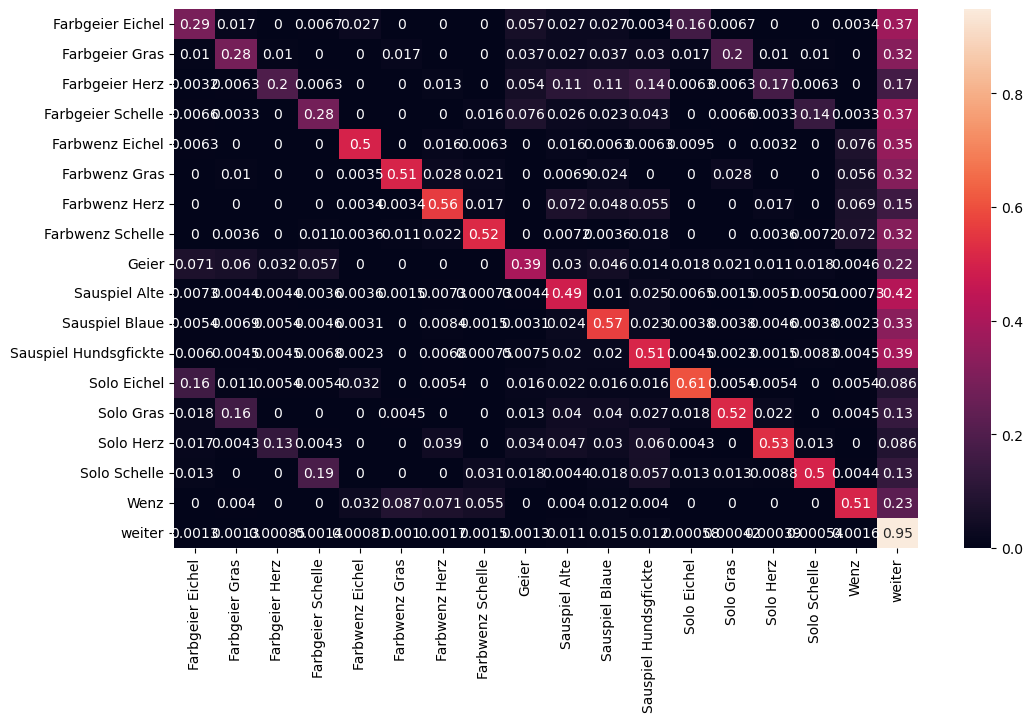

In [88]:
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in category_mapping],
                     columns = [i for i in category_mapping])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

## Example Execution

In [50]:
# Define input
X = torch.tensor(train_data[2:3].values, device=device)
# Execute
out = model(X)
# Map output
output_code = torch.max(out, 1).indices[0].item()
category_mapping = output_data.astype("category").cat.categories
print(category_mapping)
print("Example Output: ",category_mapping[output_code])

Index(['Farbgeier Eichel', 'Farbgeier Gras', 'Farbgeier Herz',
       'Farbgeier Schelle', 'Farbwenz Eichel', 'Farbwenz Gras',
       'Farbwenz Herz', 'Farbwenz Schelle', 'Geier', 'Sauspiel Alte',
       'Sauspiel Blaue', 'Sauspiel Hundsgfickte', 'Solo Eichel', 'Solo Gras',
       'Solo Herz', 'Solo Schelle', 'Wenz', 'weiter'],
      dtype='object')
Example Output:  Farbwenz Schelle


In [25]:
print(train_data[2:3].values)

[[0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  1. 1. 0. 0. 0. 0. 0. 1.]]
